# Lab 3: Image Classification with CNN using PyTorch

### Objectives
This laboratory session focuses on implementing a Convolutional Neural Network (CNN) for satellite image classification using PyTorch. Students will gain hands-on experience in designing, training, and optimizing CNN architectures while working with real-world satellite imagery. The lab covers essential concepts including convolutional layers, pooling operations, batch normalization, dropout, and early stopping, culminating in model export and evaluation.

### Dataset Information
We will be using the "EuroSAT" dataset, which contains 27,000 labeled satellite images across 10 different land use and land cover classes. Each image is a 64x64 pixel RGB image. We use some of them classes for this lab.

Dataset link: https://github.com/phelber/eurosat

**Classes:**
1. Annual Crop
2. Permanent Crop
3. River
4. Sea & Lake
5. Highway
6. Forest

### Tasks
1. **Data Preparation**
   - Download and explore the EuroSAT dataset
   - Implement data loading and preprocessing
   - Create train/validation/test splits
   - Apply data augmentation techniques

2. **CNN Architecture Design**
   - Implement a basic CNN architecture
   - Understand and configure kernel sizes, stride, and padding
   - Add pooling layers (max and average pooling)
   - Implement fully connected layers

3. **Model Optimization**
   - Add Batch Normalization layers
   - Implement Dropout for regularization
   - Configure Early Stopping mechanism
   - Experiment with different optimizers and learning rates

4. **Training and Evaluation**
   - Train the model with and without optimization techniques
   - Monitor training metrics
   - Implement learning rate scheduling
   - Evaluate model performance

### How CNN works?
A Convolutional Neural Network (CNN) works by processing an image through a series of layers to identify and classify the objects in it: 
1. Convolutional layer
    - The first layer in a CNN, which uses filters to convolve with the image to create an activation map. 

2. Activation layer
    - Applies a non-linear activation function, such as ReLU, to the output of the pooling layer. This helps the CNN learn more complex representations of the data. 

3. Pooling layer
    - Uses filters to identify different parts of the image, such as edges and corners. The pooling layer reduces the dimensionality of the feature map, which speeds up computation and reduces memory. 

4. Fully connected layer
    - Connects every neuron from the previous layer to every neuron in the fully connected layer. This layer integrates the features extracted in the previous layers and maps them to specific classes or outcomes. 

In [55]:
# !nvidia-smi

### Required Libraries and Setup

In [24]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.nn import functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os


In [25]:
SEED = 1234

# random.seed(SEED)
# np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Data Loading, Preprocessing and data loading

In [26]:
image_folder = "D:\\Nokia_DL_L3_lab\\EuroSAT"

In [27]:
mean = [0.5, 0.5, 0.5]
std =  [0.5, 0.5, 0.5]

In [28]:
def load_dataset(data_path):

    # Load all the images
    # Randomly augment the image data
    transformation = transforms.Compose([
        # Random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean, std)
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    return full_dataset

In [29]:
# Get the iterative dataloaders for test and training data
full_dataset = load_dataset(image_folder)
print("Data loaders ready to read", image_folder)

Data loaders ready to read D:\Nokia_DL_L3_lab\EuroSAT


In [58]:
classes = full_dataset.classes

In [59]:

# Split into training (70% and testing (30%) datasets)
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size

# use torch.utils.data.random_split for training/test split
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# define a loader for the training data we can iterate through in 50-image batches
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=500,
    num_workers=0,
    shuffle=False
)

# define a loader for the testing data we can iterate through in 50-image batches
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=500,
    num_workers=0,
    shuffle=False
)

In [60]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

### Sample Data

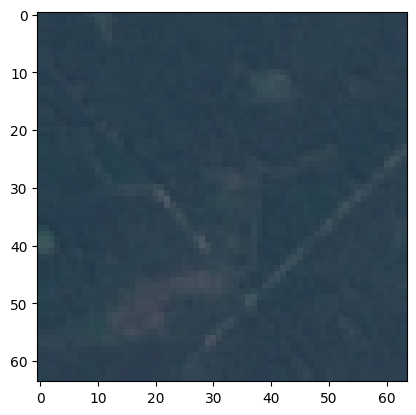

Label:  Forest


In [62]:
imshow(train_dataset[0][0])
print("Label: ", classes[train_dataset[0][1]])

### CNN Model Architecture

In [35]:
# Create a neural net class
class CNNnet(nn.Module):

    # Defining the Constructor
    def __init__(self, num_classes=10):
        super(CNNnet, self).__init__()

        # In the init function, we define each layer we will use in our model

        # Our images are RGB, so we have input channels = 3.
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3, stride=1, padding=1)

        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=24, kernel_size=3, stride=1, padding=1)

        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Our 64X64 image tensors will be pooled twice with a kernel size of 2. 64/2/2 is 16.
        # This means that our feature tensors are now 16 x 16, and we've generated 24 of them

        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=16 * 16 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function

        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = self.pool(F.relu(self.conv1(x)))

        # Use a ReLU activation function after layer 2
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten
        x = x.view(-1, 16 * 16 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function
        return torch.log_softmax(x, dim=1)

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [37]:
# Create an instance of the model class and allocate it to the device
model = CNNnet(num_classes=len(classes)).to(device)

print(model)

CNNnet(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=6144, out_features=6, bias=True)
)


### Training and Testing loops

In [63]:
def train(model, device, train_loader, optimizer, epoch):

    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)

    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)

        # print(output.shape)
        # print(target.shape)
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Print metrics so we see some progress
        # print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
        


    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [65]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()

            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Testing set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # return average loss for the epoch
    return avg_loss, accuracy

In [66]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

epochs = 20
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss, acc = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cuda
Epoch: 1
Training set: Average loss: 1.486689
Testing set: Average loss: 0.783658, Accuracy: 3465/5100 (68%)

Epoch: 2
Training set: Average loss: 0.664215
Testing set: Average loss: 0.538084, Accuracy: 4041/5100 (79%)

Epoch: 3
Training set: Average loss: 0.472326
Testing set: Average loss: 0.504485, Accuracy: 4125/5100 (81%)

Epoch: 4
Training set: Average loss: 0.409407
Testing set: Average loss: 0.382344, Accuracy: 4387/5100 (86%)

Epoch: 5
Training set: Average loss: 0.351420
Testing set: Average loss: 0.358304, Accuracy: 4451/5100 (87%)

Epoch: 6
Training set: Average loss: 0.316310
Testing set: Average loss: 0.332839, Accuracy: 4505/5100 (88%)

Epoch: 7
Training set: Average loss: 0.296192
Testing set: Average loss: 0.384733, Accuracy: 4386/5100 (86%)

Epoch: 8
Training set: Average loss: 0.303093
Testing set: Average loss: 0.324226, Accuracy: 4513/5100 (88%)

Epoch: 9
Training set: Average loss: 0.276628
Testing set: Average loss: 0.321045, Accuracy: 4547/5100 

### Plotting training and validation losses

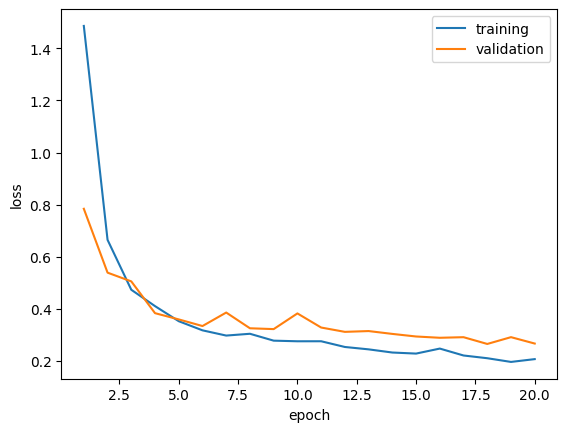

In [67]:
plt.figure()
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Training Loop with Optimization Techniques - With batch normalization and early stopping

In [68]:
class CNNnet1(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNnet1, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3, stride=1, padding=1)
        # self.conv2 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(20)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(24)
        
        # Pooling and dropout
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.drop = nn.Dropout2d(p=0.2)
        
        # Fully connected layer
        self.fc = nn.Linear(in_features=16 * 16 * 24, out_features=num_classes)

    def forward(self, x):
        # First block: Conv -> BatchNorm -> ReLU -> Pool
        x = self.conv1(x)
        # x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Second block: Conv -> BatchNorm -> ReLU -> Pool
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Dropout
        x = self.drop(x)
        
        # Flatten and feed to fully connected layer
        x = x.view(-1, 16 * 16 * 24)
        x = self.fc(x)
        
        return torch.log_softmax(x, dim=1)

In [69]:
# Use an "Adam" optimizer to adjust weights
model1 = CNNnet1(len(classes)).to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=0.01)

# Specify the loss criteria
loss_criteria1 = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums1 = []
training_loss1 = []
validation_loss1 = []


print(model1)

CNNnet1(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=6144, out_features=6, bias=True)
)


In [70]:
epochs = 30

best_accuracy = -1
early_stop_thresh = 5


print('Training on', device)

for epoch in range(1, epochs + 1):
        train_loss = train(model1, device, train_loader, optimizer1, epoch)
        test_loss, acc = test(model1, device, test_loader)
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
        elif epoch - best_epoch > early_stop_thresh:
            print("Early stopped training at epoch %d" % epoch)
            break  # terminate the training loop
    
        epoch_nums1.append(epoch)
        training_loss1.append(train_loss)
        validation_loss1.append(test_loss)

Training on cuda
Epoch: 1
Training set: Average loss: 6.051547
Testing set: Average loss: 2.471620, Accuracy: 1855/5100 (36%)

Epoch: 2
Training set: Average loss: 1.728463
Testing set: Average loss: 1.308100, Accuracy: 2590/5100 (51%)

Epoch: 3
Training set: Average loss: 1.316040
Testing set: Average loss: 1.305446, Accuracy: 2750/5100 (54%)

Epoch: 4
Training set: Average loss: 1.191673
Testing set: Average loss: 1.754185, Accuracy: 2381/5100 (47%)

Epoch: 5
Training set: Average loss: 1.036223
Testing set: Average loss: 1.000470, Accuracy: 2967/5100 (58%)

Epoch: 6
Training set: Average loss: 0.855498
Testing set: Average loss: 0.843346, Accuracy: 3475/5100 (68%)

Epoch: 7
Training set: Average loss: 0.704369
Testing set: Average loss: 0.704968, Accuracy: 3912/5100 (77%)

Epoch: 8
Training set: Average loss: 0.604896
Testing set: Average loss: 0.867081, Accuracy: 3541/5100 (69%)

Epoch: 9
Training set: Average loss: 0.564415
Testing set: Average loss: 0.592206, Accuracy: 4093/5100 

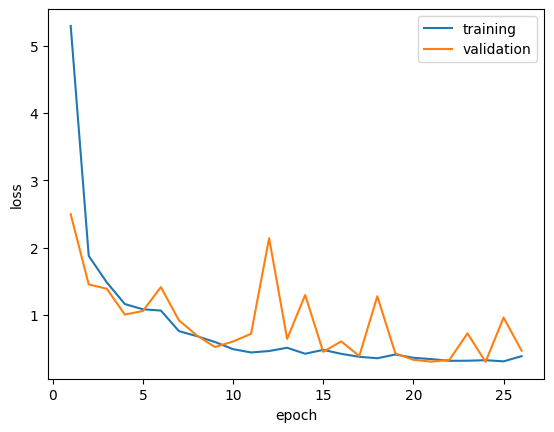

In [46]:
plt.figure()
plt.plot(epoch_nums1, training_loss1)
plt.plot(epoch_nums1, validation_loss1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Testing on random images

In [47]:
def predict_img(img, model):
    # data, target = data.to(device), target.to(device)
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    
    _, pred = torch.max(yb, dim=1)
    return pred    

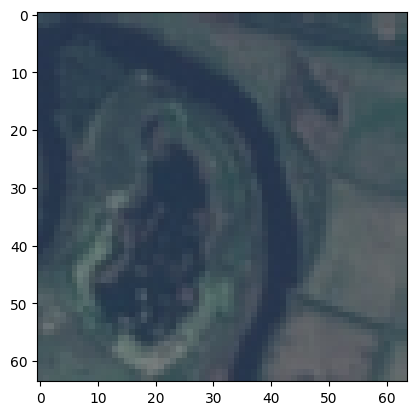

Label: River , Predicted: River


In [49]:
img, label = test_dataset[10]
imshow(img)
print('Label:', classes[label], ', Predicted:', classes[predict_img(img, model1).item()])

Label: River , Predicted: River


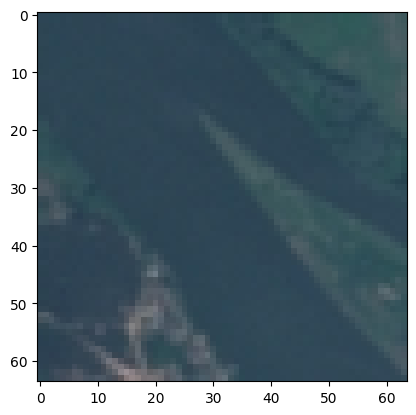

Label: AnnualCrop , Predicted: AnnualCrop


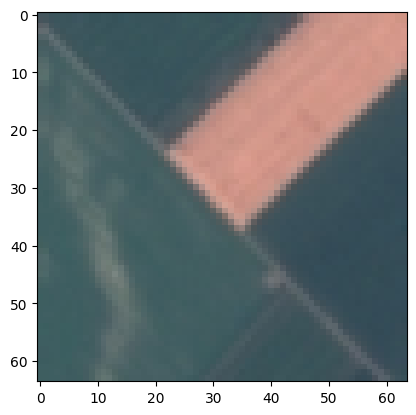

Label: SeaLake , Predicted: SeaLake


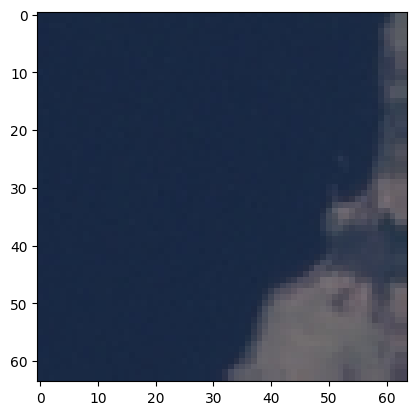

Label: Highway , Predicted: Highway


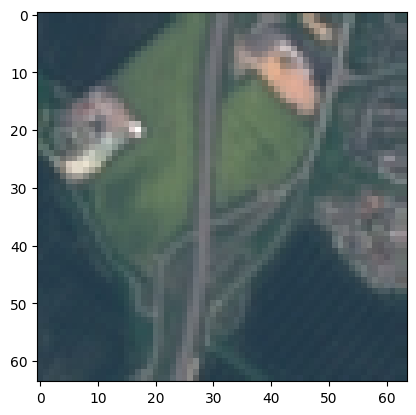

Label: River , Predicted: SeaLake


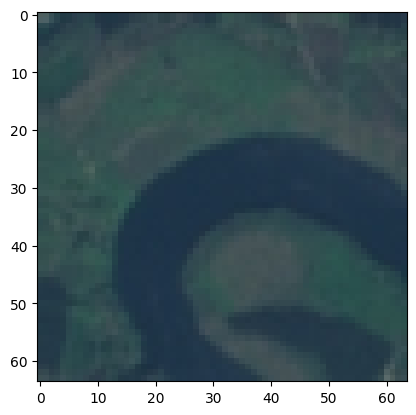

In [55]:
for i in torch.randint(low=1, high=5000, size=(5,)):
    # print(i.item())
    img, label = test_dataset[i.item()]
    print('Label:', classes[label], ', Predicted:', classes[predict_img(img, model1).item()])
    imshow(img)